In [31]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder
from matplotlib.patches import Circle, Rectangle, Arc

df = pd.read_csv("all_shot_data.csv")
#convert game clock
df['GAME_CLOCK'] = (df['PERIOD'] - 1) * 12 + (12 - df['MINUTES_REMAINING'] - df['SECONDS_REMAINING'] / 60)
#drop unneccessary columns
columns_to_drop = ['GRID_TYPE','GAME_ID','TEAM_ID','PLAYER_ID','GAME_EVENT_ID','SHOT_ATTEMPTED_FLAG',
'GAME_DATE','HTM','VTM','HOME_TEAM_NAME',"AWAY_TEAM_NAME", 'TEAM_NAME', "MINUTES_REMAINING",
"SECONDS_REMAINING","PERIOD","EVENT_TYPE","SHOT_ZONE_AREA",'SHOT_ZONE_RANGE','Season Type','SHOT_ZONE_BASIC',"player_name","LOCATION", "LOC_X","LOC_Y"]
df = df.drop(columns = columns_to_drop)

In [32]:
#categorize all actions into four type of shots
def action_type_processor(action):
    lower_case = action.lower()
    if 'dunk' in lower_case:
        return 0
    elif 'layup' in lower_case:
        return 1
    elif 'hook' in lower_case:
        return 2
    elif 'jump'in lower_case or 'fadeaway' in lower_case:
        return 3
def shot_type_processor(shot):
    if shot == '3PT Field Goal':
        return 3
    else:
        return 2
df['ACTION_TYPE'] = df['ACTION_TYPE'].apply(action_type_processor)
df['SHOT_TYPE'] = df['SHOT_TYPE'].apply(shot_type_processor)

In [34]:
#second data set rating
with open('league.json') as f:
    data = json.load(f)

df_rating = pd.DataFrame(data)
columns_to_keep = ['name','overallAttribute', 'closeShot','midRangeShot','threePointShot','postHook','drivingDunk']
df_rating = df_rating[columns_to_keep]

In [35]:
def fill_attributes(row,df_rating):
    player_name = row['PLAYER_NAME']
    action_type = row['ACTION_TYPE']
    point = row['SHOT_TYPE']
    
    if player_name not in df_rating['name'].values:
        return np.nan, np.nan
    if action_type == 0:
        rating = df_rating.loc[df_rating['name'] == player_name, 'closeShot'].values[0]
    elif action_type == 1:
        rating = df_rating.loc[df_rating['name'] == player_name, 'drivingDunk'].values[0]
    elif action_type == 2:
        rating = df_rating.loc[df_rating['name'] == player_name, 'postHook'].values[0]
    elif action_type == 3:
        if point == 2:
            rating = df_rating.loc[df_rating['name'] == player_name, 'midRangeShot'].values[0]
        elif point == 3:
            rating = df_rating.loc[df_rating['name'] == player_name, 'threePointShot'].values[0]
    overall = df_rating.loc[df_rating['name'] == player_name, 'overallAttribute'].values[0]
    return rating, overall

In [49]:
df

,ACTION_TYPE,SHOT_TYPE,SHOT_DISTANCE,SHOT_MADE_FLAG,GAME_CLOCK,rating,overall
0,0,2,1,1,10.183333,66.0,76.0
1,3,3,23,0,11.816667,67.0,76.0
2,3,3,22,0,15.183333,67.0,76.0
3,0,2,0,1,38.500000,66.0,76.0
4,3,3,26,0,11.466667,67.0,76.0
...,...,...,...,...,...,...,...
232536,0,2,0,1,23.400000,98.0,82.0
232537,3,2,6,0,24.316667,74.0,82.0
232538,2,2,7,1,36.933333,81.0,82.0
232539,3,2,17,0,38.283333,74.0,82.0


In [36]:
df[['rating', 'overall']] = df.apply(fill_attributes, axis=1, df_rating=df_rating, result_type="expand")
df = df.drop(columns = ['PLAYER_NAME'])
df = df.dropna()

### Logistic Regression

In [45]:
# Define features and target
X = df.drop(columns=['SHOT_MADE_FLAG'])
y = df['SHOT_MADE_FLAG']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Decision Tree Classifier
clf = LogisticRegression(random_state=42, max_iter=1000)  # Increased max_iter for convergence
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
c
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(report)

Accuracy: 0.61
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.66      0.64     22186
           1       0.60      0.55      0.57     20323

    accuracy                           0.61     42509
   macro avg       0.61      0.60      0.60     42509
weighted avg       0.61      0.61      0.61     42509



In [47]:
# Get feature names
feature_names = X.columns

# Get coefficients and intercept
coefficients = clf.coef_[0]
intercept = clf.intercept_[0]

# Print the formula
print("Logistic Regression Formula:")
print(f"P(scored) = 1 / (1 + e^-({intercept:.4f}", end='')
for feat, coef in zip(feature_names, coefficients):
    print(f" + {coef:.4f}*{feat}", end='')
print("))")

# Print feature importance
print("\nFeature Coefficients:")
for feat, coef in zip(feature_names, coefficients):
    print(f"{feat}: {coef:.4f}")

Logistic Regression Formula:
P(scored) = 1 / (1 + e^-(-2.3997 + 0.0849*ACTION_TYPE + 0.8264*SHOT_TYPE + -0.0870*SHOT_DISTANCE + -0.0012*GAME_CLOCK + 0.0106*rating + 0.0058*overall))

Feature Coefficients:
ACTION_TYPE: 0.0849
SHOT_TYPE: 0.8264
SHOT_DISTANCE: -0.0870
GAME_CLOCK: -0.0012
rating: 0.0106
overall: 0.0058


In [48]:
# Print feature importances (coefficients for logistic regression)
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': abs(clf.coef_[0])  # Take absolute values of coefficients
})

# Sort by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(importance_df)


Feature Importances:
         Feature  Importance
1      SHOT_TYPE    0.826418
2  SHOT_DISTANCE    0.086955
0    ACTION_TYPE    0.084898
4         rating    0.010585
5        overall    0.005785
3     GAME_CLOCK    0.001197


In [ ]:
# Predict probabilities
y_prob = model.predict_proba(X_test)

# Display probability for each class
print("Probability for each class (missed=0, scored=1):")
print(y_prob)

In [15]:
# steph_df = df.loc[df['PLAYER_NAME'] == 'Stephen Curry']
# steph_df = df.drop(columns=['PLAYER_NAME',"LOC_X","LOC_Y"])

# # Encode categorical variables
# # label_encoder = LabelEncoder()
# # steph_df['ACTION_TYPE'] = label_encoder.fit_transform(steph_df['ACTION_TYPE'])
# one_hot_encoder = OneHotEncoder(sparse_output = False)

# # Apply OneHotEncoder to the ACTION_TYPE column and convert to a DataFrame
# action_type_encoded = one_hot_encoder.fit_transform(steph_df[['ACTION_TYPE']])
# # Convert the one-hot encoded data to a DataFrame with the appropriate column names
# action_type_df = pd.DataFrame(action_type_encoded, columns=one_hot_encoder.get_feature_names_out(['ACTION_TYPE']))

# # Concatenate the one-hot encoded columns back to the original DataFrame
# steph_df = pd.concat([steph_df.drop('ACTION_TYPE', axis=1), action_type_df], axis=1)

# # Define features and target
# X = steph_df.drop(columns=['SHOT_MADE_FLAG'])
# y = steph_df['SHOT_MADE_FLAG']

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Train a Decision Tree Classifier
# clf = DecisionTreeClassifier(random_state=42, max_depth = 4)
# clf.fit(X_train, y_train)

# # Make predictions
# y_pred = clf.predict(X_test)

# # Evaluate the model
# accuracy = accuracy_score(y_test, y_pred)
# report = classification_report(y_test, y_pred)

# print(f"Accuracy: {accuracy:.2f}")
# print("Classification Report:")
# print(report)

In [40]:
# Define features and target
X = df.drop(columns=['SHOT_MADE_FLAG'])
y = df['SHOT_MADE_FLAG']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42, max_depth = 10)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(report)


Accuracy: 0.62
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.80      0.69     24384
           1       0.66      0.43      0.52     22125

    accuracy                           0.62     46509
   macro avg       0.63      0.61      0.61     46509
weighted avg       0.63      0.62      0.61     46509



In [127]:
df

,ACTION_TYPE,SHOT_TYPE,SHOT_DISTANCE,SHOT_MADE_FLAG,GAME_CLOCK,rating,overall
0,0,2,1,1,10.183333,66.0,76.0
1,3,3,23,0,11.816667,67.0,76.0
2,3,3,22,0,15.183333,67.0,76.0
3,0,2,0,1,38.500000,66.0,76.0
4,3,3,26,0,11.466667,67.0,76.0
...,...,...,...,...,...,...,...
232536,0,2,0,1,23.400000,98.0,82.0
232537,3,2,6,0,24.316667,74.0,82.0
232538,2,2,7,1,36.933333,81.0,82.0
232539,3,2,17,0,38.283333,74.0,82.0


In [130]:
feature_importances = clf.feature_importances_

# Create a DataFrame to show the features and their importances
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print("Feature Importances:")
print(importance_df)

Feature Importances:
         Feature  Importance
2  SHOT_DISTANCE    0.687990
0    ACTION_TYPE    0.155277
3     GAME_CLOCK    0.070771
4         rating    0.056326
5        overall    0.029576
1      SHOT_TYPE    0.000060


In [112]:
plt.figure(figsize=(20, 10))  # Increase the size if necessary
plot_tree(clf, filled=True, feature_names=X.columns, class_names=["Miss", "Make"], rounded=True)
plt.savefig("decision_tree.png", dpi=300)  # Set dpi for higher resolution
plt.close()  # Close the figure if you’re running this outside a notebook

In [82]:
def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]
    if outer_lines:
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)
    for element in court_elements:
        ax.add_patch(element)
    return ax

In [83]:
wiseman_df = df[df['PLAYER_NAME'] == 'James Wiseman']

KeyError: 'PLAYER_NAME'

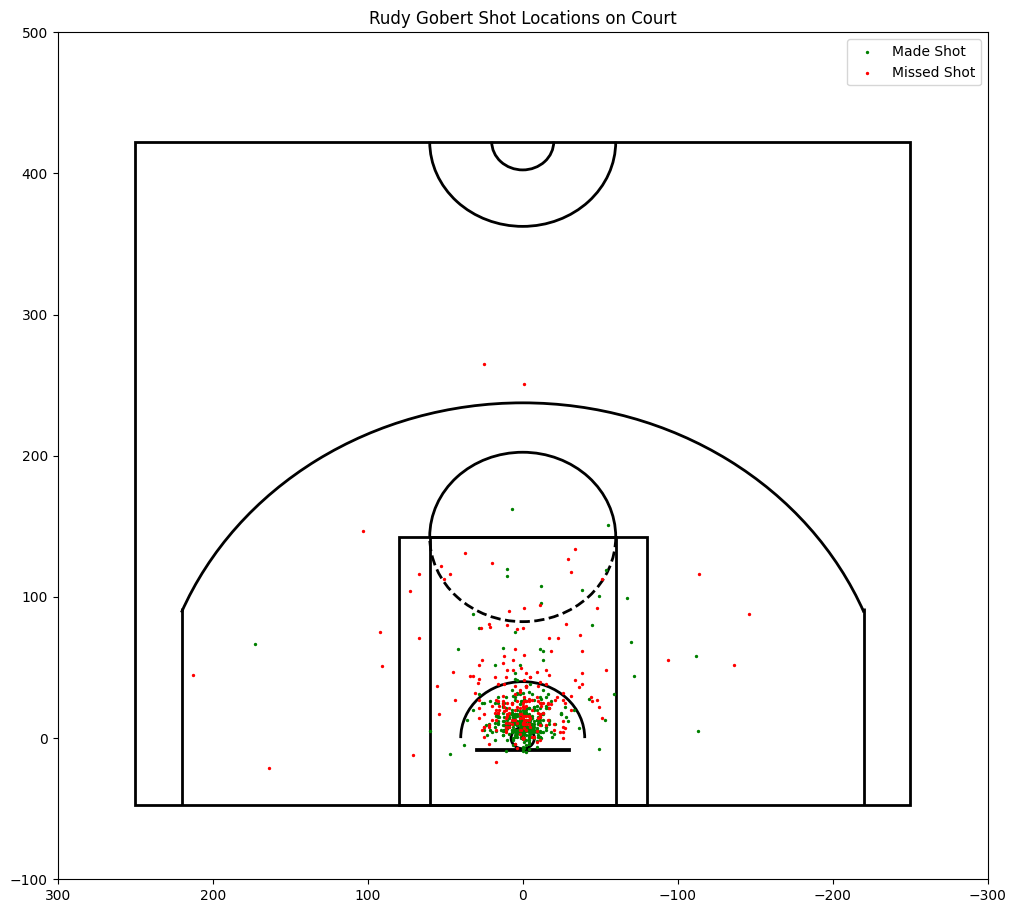

In [ ]:
def player_shotChart(name):
    player_df = df[df['PLAYER_NAME'] == name]
    plt.figure(figsize=(12, 11))
    draw_court(outer_lines=True) 

    plt.scatter(player_df.LOC_X[player_df.SHOT_MADE_FLAG == 1], 
                player_df.LOC_Y[player_df.SHOT_MADE_FLAG == 1], 
                color='green', label='Made Shot', s=2)

    plt.scatter(player_df.LOC_X[player_df.SHOT_MADE_FLAG == 0], 
                player_df.LOC_Y[player_df.SHOT_MADE_FLAG == 0], 
                color='red', label='Missed Shot', s=2)

    plt.xlim(300, -300)  # Set x-axis limits
    plt.ylim(-100, 500)  # Set y-axis limits
    plt.title(f'{name} Shot Locations on Court')
    plt.legend()
    plt.show()
player_shotChart('Rudy Gobert')